<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap15/15_1_GAN_Toy_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 15.1: GAN Toy example**

This notebook investigates the GAN toy example as illustrated in figure 15.1 in the book.

Work through the cells below, running each cell in turn. In various places you will see the words "TODO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [111]:
import numpy as np
import matplotlib.pyplot as plt

In [112]:
# Get a batch of real data.  Our goal is to make data that looks like this.
def get_real_data_batch(n_sample):
  np.random.seed(0)
  x_true = np.random.normal(size=(1,n_sample)) + 7.5
  return x_true

Define our generator.  This takes a standard normally-distributed latent variable $z$ and adds a scalar $\theta$ to this, where $\theta$ is the single parameter of this generative model according to:

\begin{equation}
x_i = z_i + \theta.
\end{equation}

Obviously this model can generate the family of Gaussian distributions with unit variance, but different means.

In [113]:
# This is our generator -- takes the single parameter theta
# of the generative model and generates n samples
def generator(z, theta):
    x_gen = z + theta
    return x_gen

Now, we define our discriminator.  This is a simple logistic regression model (1D linear model passed through sigmoid) that returns the probability that the data is real

In [114]:
# Define our discriminative model

# Logistic sigmoid, maps from [-infty,infty] to [0,1]
def sig(data_in):
  return  1.0 / (1.0+np.exp(-data_in))

# Discriminator computes y
def discriminator(x, phi0, phi1):
  return sig(phi0 + phi1 * x)

In [115]:
# Draws a figure like Figure 15.1a
def draw_data_model(x_real, x_syn, phi0=None, phi1=None):
  fix, ax = plt.subplots();

  for x in x_syn:
    ax.plot([x,x],[0,0.33],color='#f47a60')
  for x in x_real:
    ax.plot([x,x],[0,0.33],color='#7fe7dc')

  if phi0 is not None:
    x_model = np.arange(0,10,0.01)
    y_model = discriminator(x_model, phi0, phi1)
    ax.plot(x_model, y_model,color='#dddddd')
  ax.set_xlim([0,10])
  ax.set_ylim([0,1])


  plt.show()

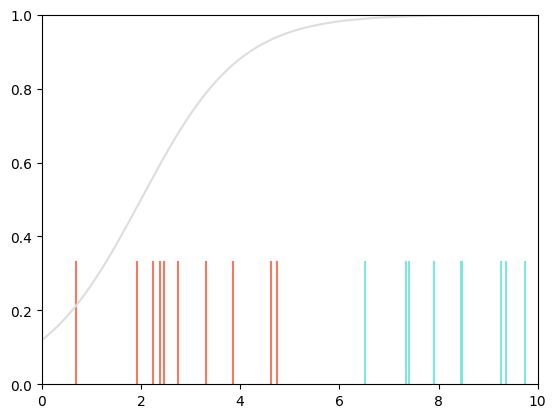

In [116]:
# Get data batch
x_real = get_real_data_batch(10)

# Initialize generator and synthesize a batch of examples
theta = 3.0
np.random.seed(1)
z = np.random.normal(size=(1,10))
x_syn = generator(z, theta)

# Initialize discriminator model
phi0 = -2
phi1 = 1

draw_data_model(x_real, x_syn, phi0, phi1)

You can see that the synthesized (orange) samples don't look much like the real (cyan) ones, and the initial model to discriminate them (gray line represents probability of being real) is pretty bad as well.

Let's deal with the discriminator first.  Let's define the loss

In [117]:
# Discriminator loss
def compute_discriminator_loss(x_real, x_syn, phi0, phi1):

  # TODO -- compute the loss for the discriminator
  # Run the real data and the synthetic data through the discriminator
  # Then use the standard binary cross entropy loss with the y=1 for the real samples
  # and y=0 for the synthesized ones.
  # Replace this line
  
  # probabilities that xi is real => 1-xi == probabilities that xi is fake
  prob_real = discriminator(x_real, phi0, phi1)
  prob_syn  = discriminator(x_syn , phi0, phi1)
  
  
  n = x_real.shape[0]
  # y=1 for real data and y=0 for fake is the ground truth
  # we dont calculate it
  # we want to maximize np.log(prob_real) and minimize np.log(prob_syn) => maximize np.log(1 - prob_syn)
  loss = -1/n * np.sum(np.log(prob_real) + np.log(1 - prob_syn))

  return loss

In [118]:
# Test the loss
loss = compute_discriminator_loss(x_real, x_syn, phi0, phi1)
print("True Loss = 13.814757170851447, Your loss=", loss )

True Loss = 13.814757170851447, Your loss= 13.814757170851447


In [119]:
# Gradient of loss (cheating, using finite differences)
def compute_discriminator_gradient(x_real, x_syn, phi0, phi1):
  delta = 0.0001;
  loss1 = compute_discriminator_loss(x_real, x_syn, phi0, phi1)
  loss2 = compute_discriminator_loss(x_real, x_syn, phi0+delta, phi1)
  loss3 = compute_discriminator_loss(x_real, x_syn, phi0, phi1+delta)
  dl_dphi0 = (loss2-loss1) / delta
  dl_dphi1 = (loss3-loss1) / delta

  return dl_dphi0, dl_dphi1

# This routine performs gradient descent with the discriminator
def update_discriminator(x_real, x_syn, n_iter, phi0, phi1):

  # Define learning rate
  alpha = 0.01

  # Get derivatives
  print("Initial discriminator loss = ", compute_discriminator_loss(x_real, x_syn, phi0, phi1))
  for iter in range(n_iter):
    # Get gradient
    dl_dphi0, dl_dphi1 = compute_discriminator_gradient(x_real, x_syn, phi0, phi1)
    # Take a gradient step downhill
    phi0 = phi0 - alpha * dl_dphi0 ;
    phi1 = phi1 - alpha * dl_dphi1 ;

  print("Final Discriminator Loss= ", compute_discriminator_loss(x_real, x_syn, phi0, phi1))

  return phi0, phi1

Initial parameters (phi0,phi1) -2 1
Initial discriminator loss =  13.814757170851447
Final Discriminator Loss=  3.7329024780307347
Final parameters (phi0,phi1) -3.5540834577190576 0.7143290523577974


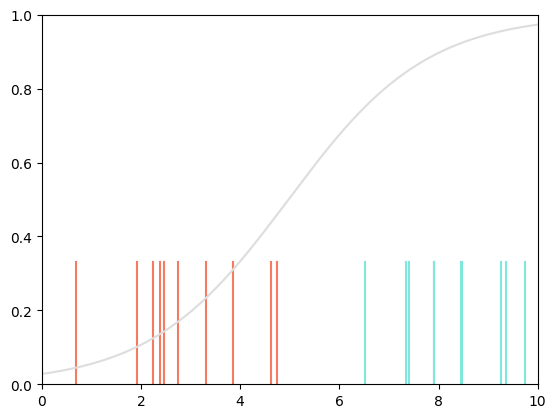

In [120]:
# Let's update the discriminator (sigmoid curve)
n_iter = 100
print("Initial parameters (phi0,phi1)", phi0, phi1)
phi0, phi1 = update_discriminator(x_real, x_syn, n_iter, phi0, phi1)
print("Final parameters (phi0,phi1)", phi0, phi1)
draw_data_model(x_real, x_syn, phi0, phi1)

Now let's update the generator

In [121]:
def compute_generator_loss(z, theta, phi0, phi1):
  # TODO -- Run the generator on the latent variables z with the parameters theta
  # to generate new data x_syn
  # Then run the discriminator on the new data to get the probability of being real
  # The loss is the total negative log probability of being synthesized (i.e. of not being real)
  # Replace this code
  
  # generate with theta param
  x_syn = generator(z, theta)
  # probability
  prob_syn = discriminator(x_syn, phi0, phi1)
  
  # minimize prob of being fake
  loss = -np.sum(np.log(1 - prob_syn))

  return loss

In [122]:
# Test generator loss to check you have it correct
loss = compute_generator_loss(z, theta, -2, 1)
print("True Loss = 13.78437035945412, Your loss=", loss )

True Loss = 13.78437035945412, Your loss= 13.78437035945412


In [123]:
def compute_generator_gradient(z, theta, phi0, phi1):
  delta = 0.0001
  loss1 = compute_generator_loss(z,theta, phi0, phi1) ;
  loss2 = compute_generator_loss(z,theta+delta, phi0, phi1) ;
  dl_dtheta = (loss2-loss1)/ delta
  return dl_dtheta

def update_generator(z, theta, n_iter, phi0, phi1):
    # Define learning rate
    alpha = 0.02

    # Get derivatives
    print("Initial generator loss = ", compute_generator_loss(z, theta, phi0, phi1))
    for iter in range(n_iter):
      # Get gradient
      dl_dtheta = compute_generator_gradient(z, theta, phi0, phi1)
      # Take a gradient step (uphill, since we are trying to make synthesized data less well classified by discriminator)
      theta = theta + alpha * dl_dtheta ;

    print("Final generator loss = ", compute_generator_loss(z, theta, phi0, phi1))
    return theta


Theta before 3.0
Initial generator loss =  2.6027212360725263
Final generator loss =  3.1596382883031455
Theta after 3.332046333341385


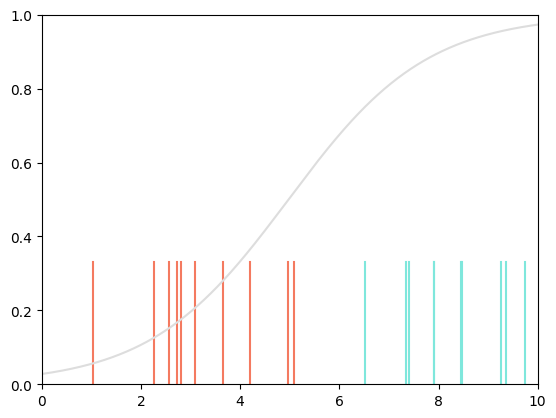

In [124]:
n_iter = 10
theta = 3.0
print("Theta before", theta)
theta = update_generator(z, theta, n_iter, phi0, phi1)
print("Theta after", theta)

x_syn = generator(z,theta)
draw_data_model(x_real, x_syn, phi0, phi1)

Final parameters (phi0,phi1) -2 1


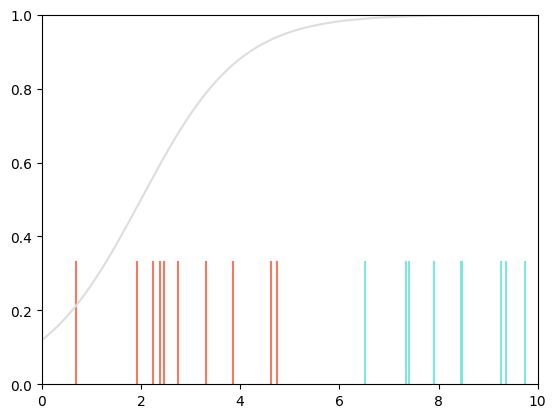

Updating discriminator
Initial discriminator loss =  13.814757170851447
Final Discriminator Loss=  2.318847463523259


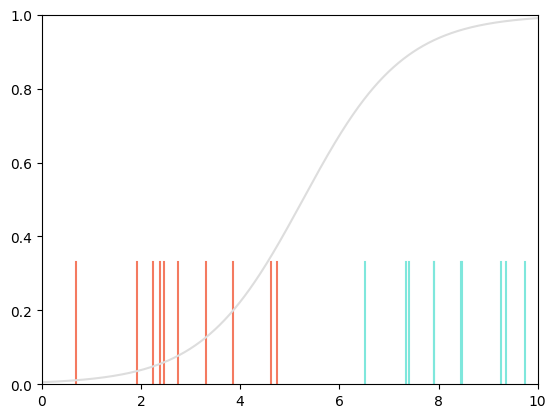

Updating generator
Initial generator loss =  1.550857159228654
Final generator loss =  1.6602077638238066


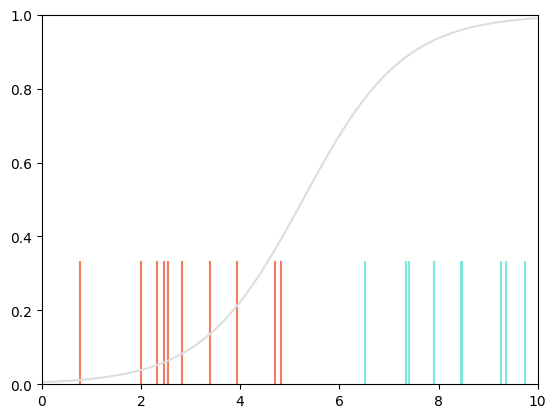

Updating discriminator
Initial discriminator loss =  2.428198068118412
Final Discriminator Loss=  1.670366640131852


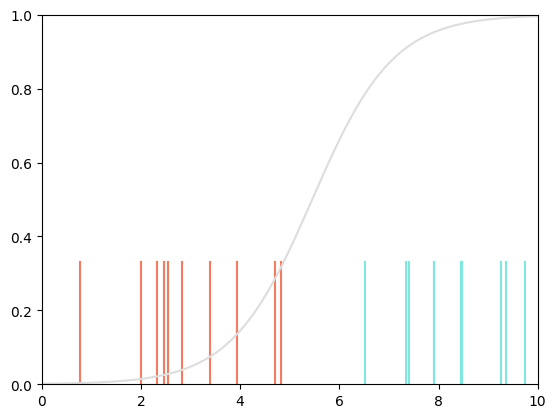

Updating generator
Initial generator loss =  1.0772376006000195
Final generator loss =  1.162183392193655


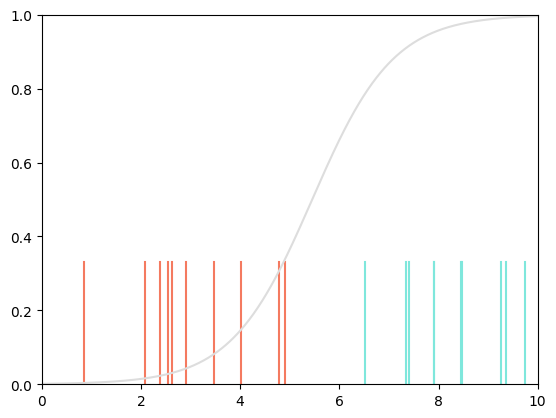

Updating discriminator
Initial discriminator loss =  1.7553124317254873
Final Discriminator Loss=  1.3890467442105572


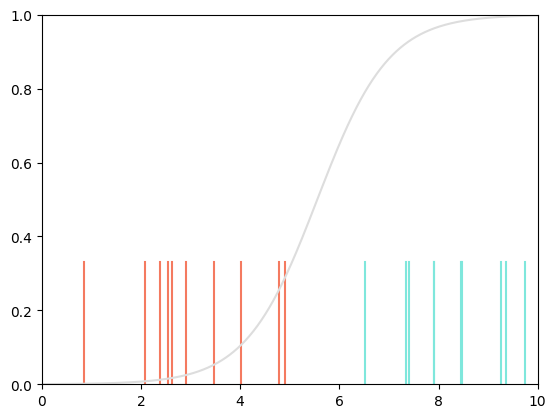

Updating generator
Initial generator loss =  0.8753580831507073
Final generator loss =  0.9491738511803783


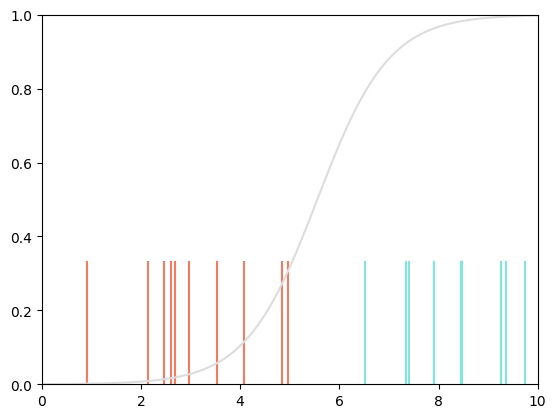

Updating discriminator
Initial discriminator loss =  1.4628625122402283
Final Discriminator Loss=  1.2335479664121267


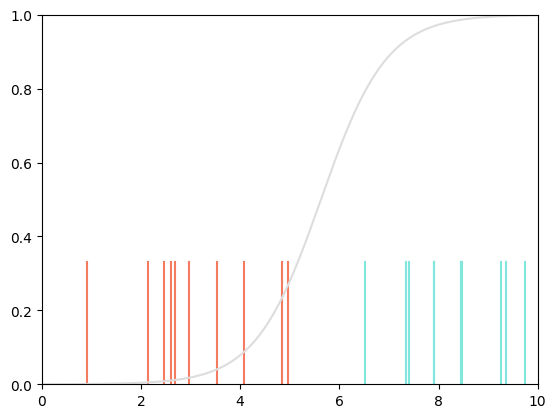

Updating generator
Initial generator loss =  0.7641039663173715
Final generator loss =  0.832200441242589


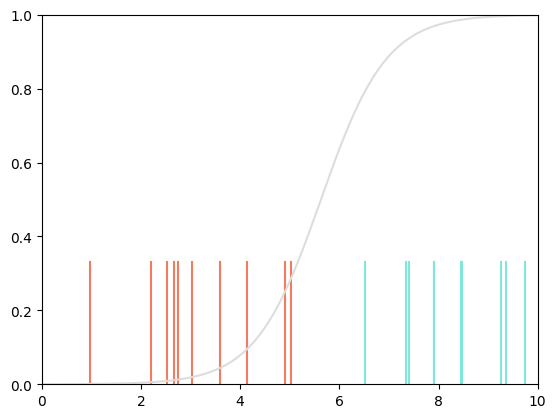

Updating discriminator
Initial discriminator loss =  1.3016444413373442
Final Discriminator Loss=  1.138263658415799


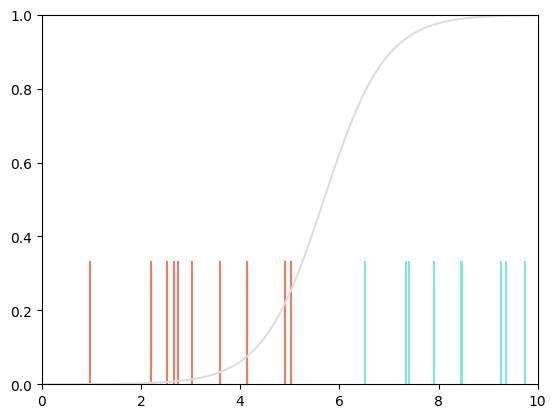

Updating generator
Initial generator loss =  0.6953116836880696
Final generator loss =  0.7605497970176757


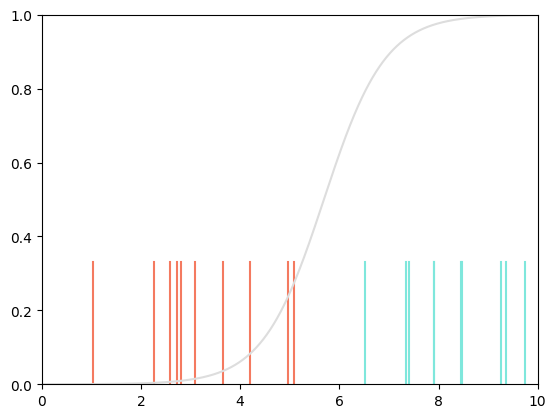

Updating discriminator
Initial discriminator loss =  1.203501771745405
Final Discriminator Loss=  1.0776268737863937


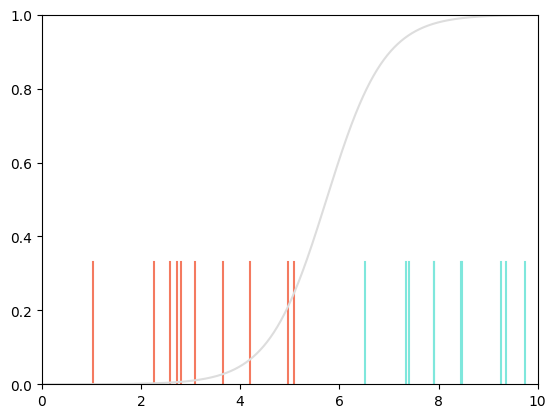

Updating generator
Initial generator loss =  0.6504590212284469
Final generator loss =  0.71465649078693


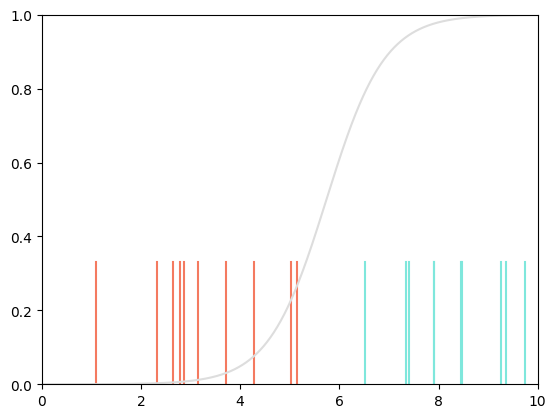

Updating discriminator
Initial discriminator loss =  1.141824343344877
Final Discriminator Loss=  1.0395905662315745


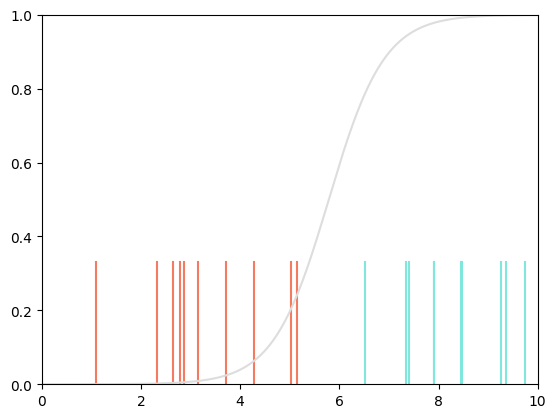

Updating generator
Initial generator loss =  0.6208797597739272
Final generator loss =  0.6853734216484108


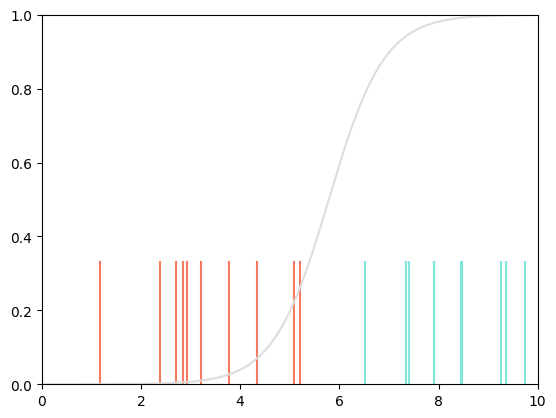

Updating discriminator
Initial discriminator loss =  1.104084228106058
Final Discriminator Loss=  1.0178148797217508


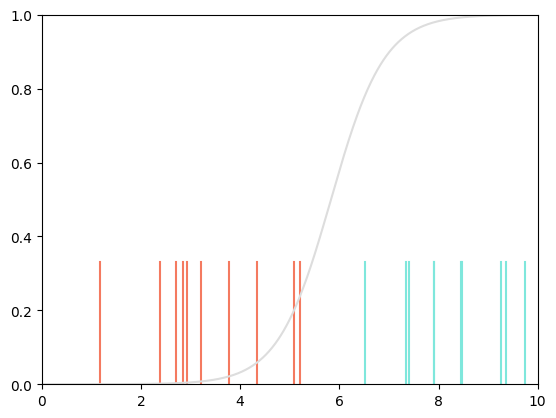

Updating generator
Initial generator loss =  0.6020124301805825
Final generator loss =  0.66791561765189


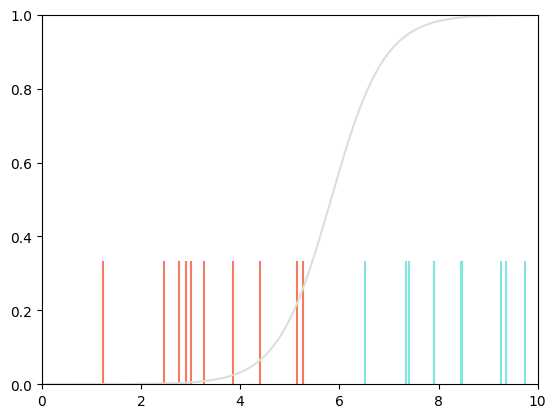

Updating discriminator
Initial discriminator loss =  1.0837180671930582
Final Discriminator Loss=  1.0087657444660991


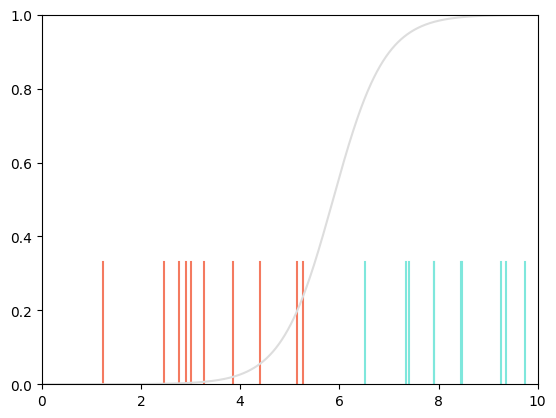

Updating generator
Initial generator loss =  0.5912844448719439
Final generator loss =  0.659627438088667


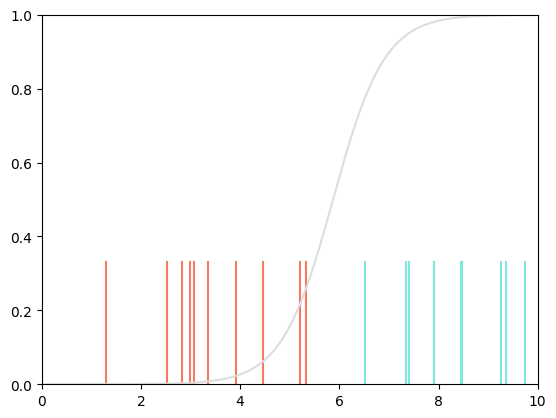

Updating discriminator
Initial discriminator loss =  1.0771087376828221
Final Discriminator Loss=  1.0104654230266696


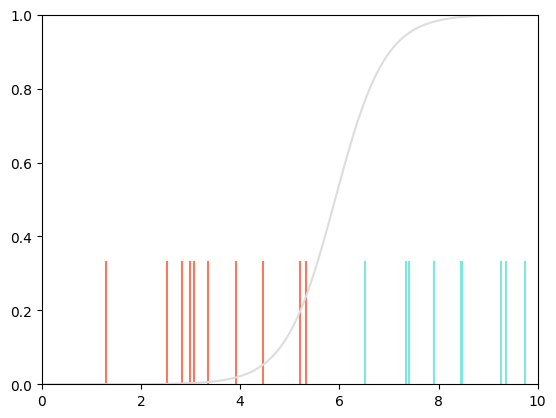

Updating generator
Initial generator loss =  0.5872056408244968
Final generator loss =  0.6590274239432359


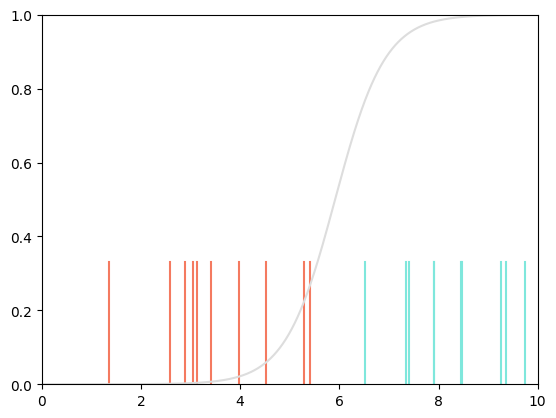

Updating discriminator
Initial discriminator loss =  1.0822872061454085
Final Discriminator Loss=  1.0219011526455302


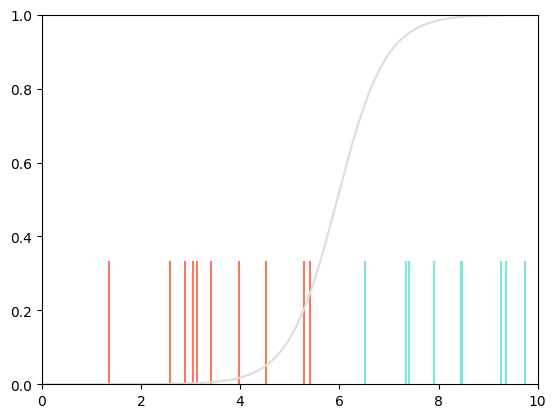

Updating generator
Initial generator loss =  0.5889384431816678
Final generator loss =  0.6653593426052625


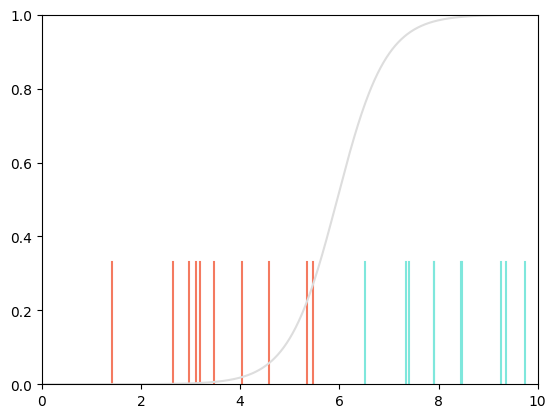

Updating discriminator
Initial discriminator loss =  1.0983220520691248
Final Discriminator Loss=  1.042732767761902


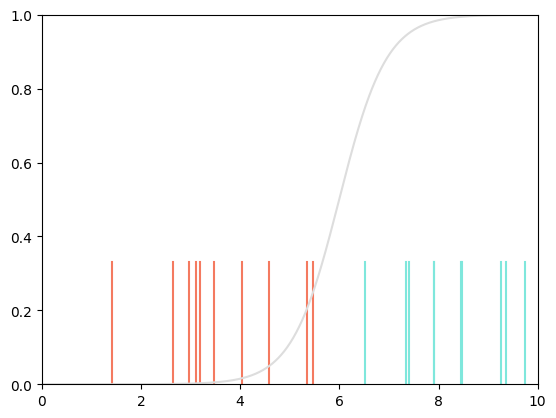

Updating generator
Initial generator loss =  0.5960815960191784
Final generator loss =  0.6783723187326601


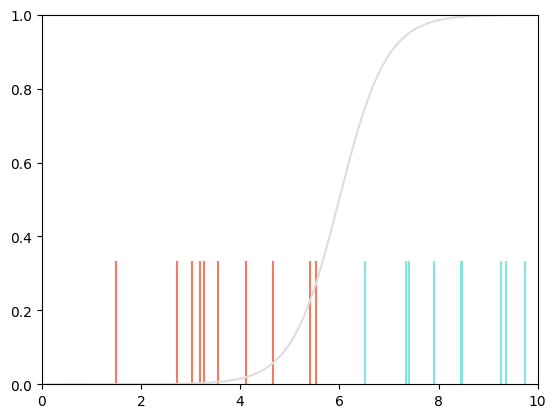

Updating discriminator
Initial discriminator loss =  1.1250234904753837
Final Discriminator Loss=  1.0731535131330392


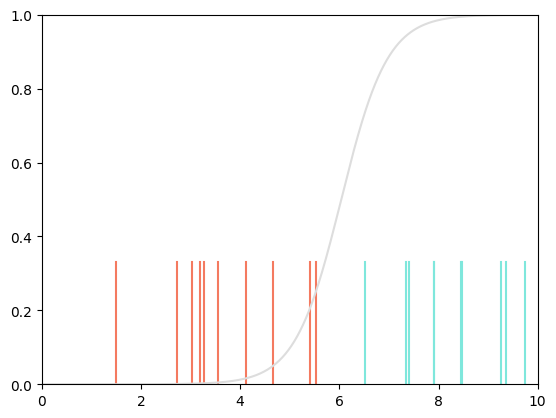

Updating generator
Initial generator loss =  0.6085608597421823
Final generator loss =  0.6982182962390431


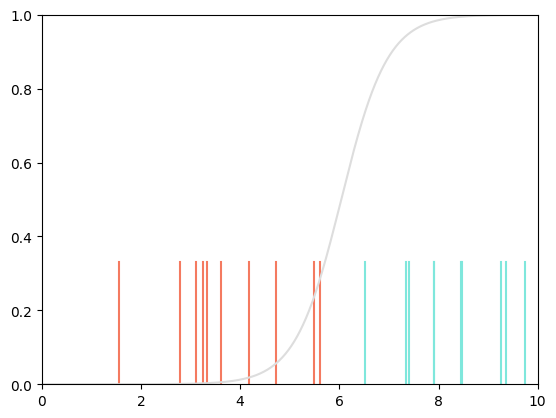

Updating discriminator
Initial discriminator loss =  1.1628109496298997
Final Discriminator Loss=  1.113840679709378


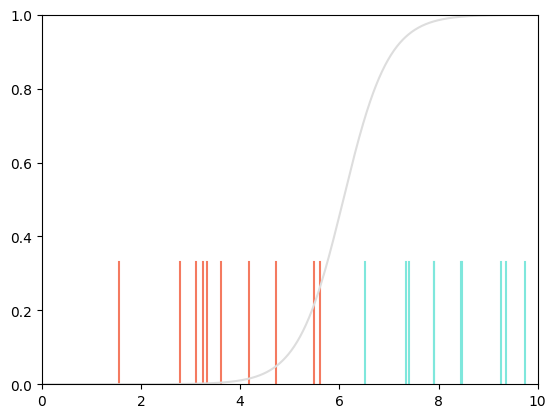

Updating generator
Initial generator loss =  0.6265798892370273
Final generator loss =  0.7254187513100204


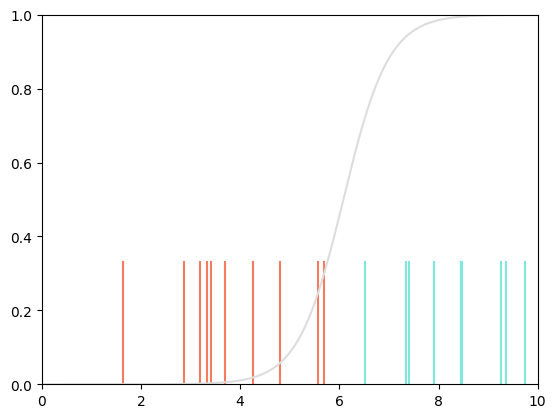

Updating discriminator
Initial discriminator loss =  1.2126795417823713
Final Discriminator Loss=  1.1659687237766427


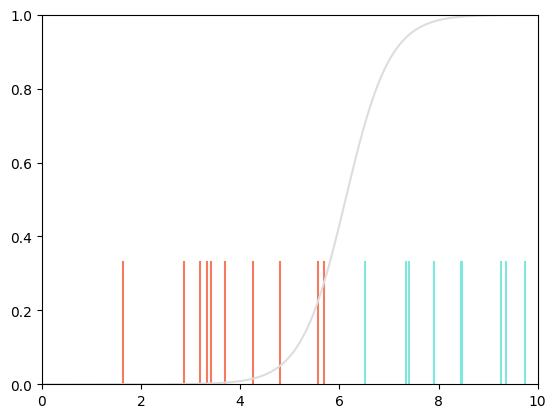

Updating generator
Initial generator loss =  0.6506102180523381
Final generator loss =  0.7608804091044247


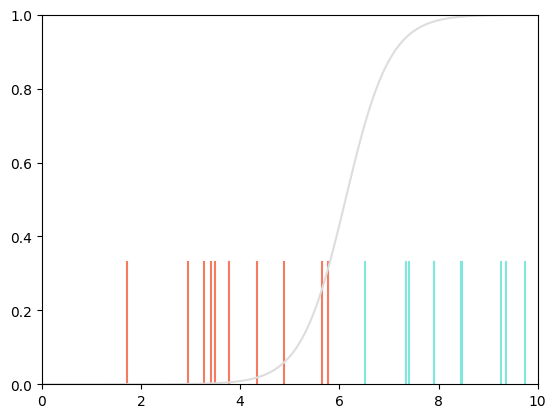

Updating discriminator
Initial discriminator loss =  1.2762389148287294
Final Discriminator Loss=  1.2312755695187565


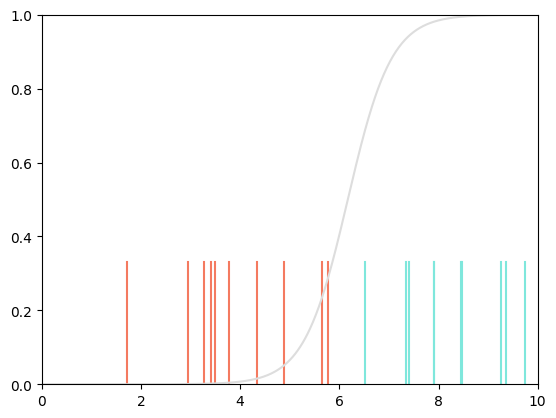

Updating generator
Initial generator loss =  0.6814117548685075
Final generator loss =  0.8059537461825697


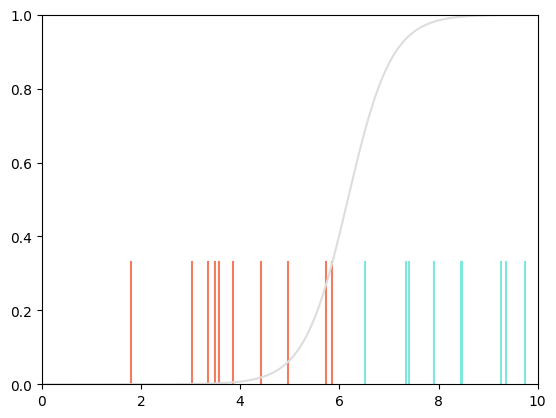

Updating discriminator
Initial discriminator loss =  1.355817560832819
Final Discriminator Loss=  1.3121835738287542


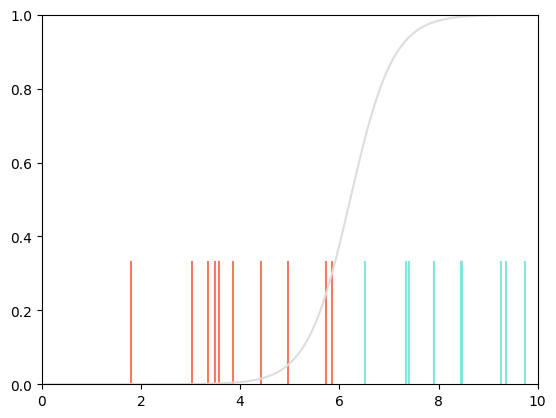

Updating generator
Initial generator loss =  0.7200823097506927
Final generator loss =  0.8625365686275875


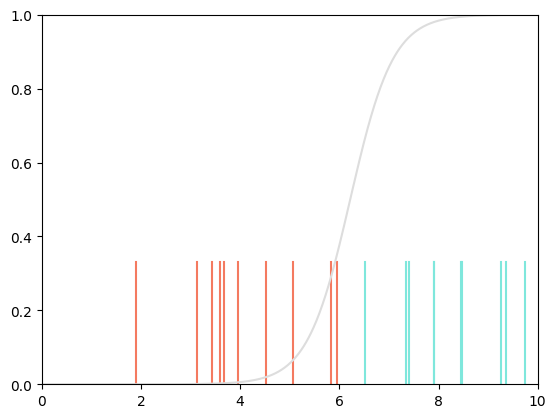

Updating discriminator
Initial discriminator loss =  1.4546378327056488
Final Discriminator Loss=  1.4119845851617783


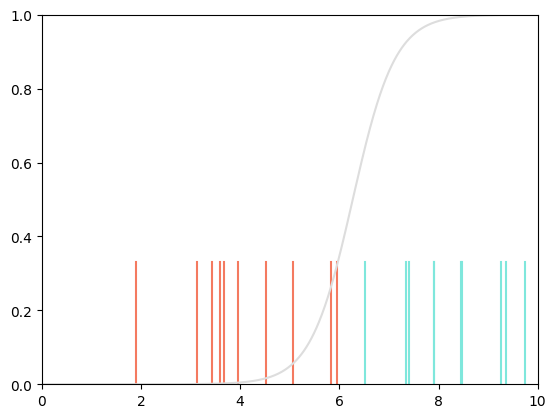

Updating generator
Initial generator loss =  0.7681397469687221
Final generator loss =  0.9332313180006847


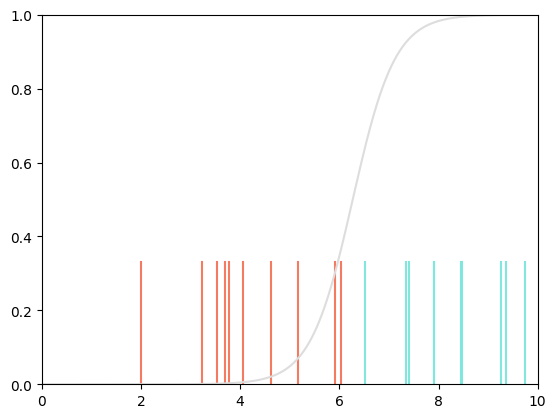

Updating discriminator
Initial discriminator loss =  1.577076156193741
Final Discriminator Loss=  1.5351054772862995


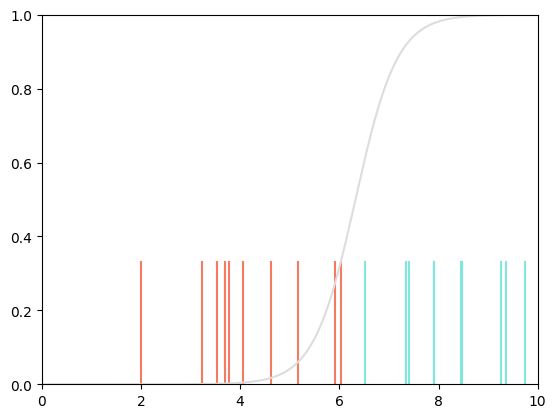

Updating generator
Initial generator loss =  0.8276450708947752
Final generator loss =  1.0215702750571


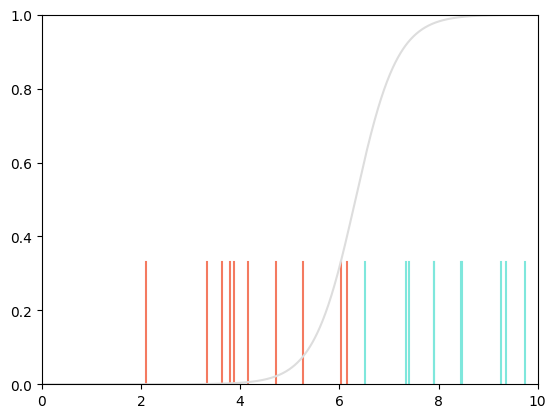

Updating discriminator
Initial discriminator loss =  1.7290306814486243
Final Discriminator Loss=  1.6874767780505153


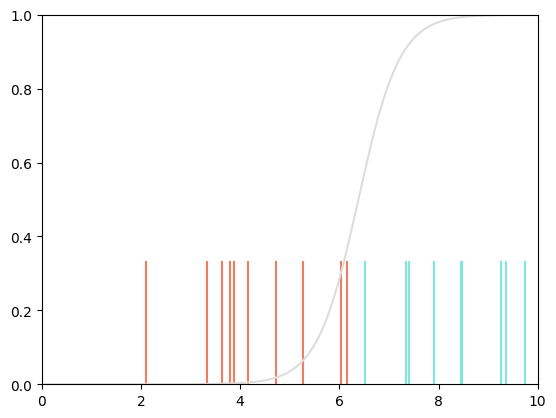

Updating generator
Initial generator loss =  0.9013801486898654
Final generator loss =  1.1323275686776828


In [ ]:
# Now let's define a full GAN loop

# Initialize the parameters
theta = 3
phi0 = -2
phi1 = 1

# Number of iterations for updating generator and discriminator
n_iter_discrim = 300
n_iter_gen = 3

print("Final parameters (phi0,phi1)", phi0, phi1)
for c_gan_iter in range(5):

  # Run generator to product synthesized data
  x_syn = generator(z, theta)
  draw_data_model(x_real, x_syn, phi0, phi1)

  # Update the discriminator
  print("Updating discriminator")
  phi0, phi1 = update_discriminator(x_real, x_syn, n_iter_discrim, phi0, phi1)
  draw_data_model(x_real, x_syn, phi0, phi1)

  # Update the generator
  print("Updating generator")
  theta = update_generator(z, theta, n_iter_gen, phi0, phi1)


You can see that the synthesized data (orange) is becoming closer to the true data (cyan).  However, this is extremely unstable -- as you will find if you mess around with the number of iterations of each optimization and the total iterations overall.